In [1]:
from qiskit import *
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt
from qiskit_aer import Aer

In [2]:
J = 1.
U = 3.
Qbits = 8
def exp_xx(dt, i, qc=QuantumCircuit(Qbits)):
    qc.cx(i+2, i+1)
    qc.cx(i+1, i)

    qc.h(i)
    qc.h(i+1)
    qc.cx(i, i+1)
    qc.rz(-J * dt,i+1)
    qc.cx(i, i+1)
    qc.h(i)
    qc.h(i+1)

    qc.cx(i+1, i)
    qc.cx(i+2, i+1)

    return qc

def exp_yy(dt, i, qc=QuantumCircuit(Qbits)):
    qc.cx(i+2, i+1)
    qc.cx(i+1, i)

    qc.s(i)
    qc.s(i+1)
    qc.h(i)
    qc.h(i+1)

    qc.cx(i, i+1)
    qc.rz(-J * dt,i+1)
    qc.cx(i, i+1)

    qc.h(i)
    qc.h(i+1)
    qc.s(i)
    qc.s(i+1)
    
    qc.cx(i+1, i)
    qc.cx(i+2, i+1)
    return qc

def exp_11(dt, i, qc=QuantumCircuit(Qbits)):
    qc.global_phase += -U * dt/4

    return qc

def exp_1z(dt, i, qc=QuantumCircuit(Qbits)):
    qc.rz(U * dt/2,i+1)
    
    return qc

def exp_z1(dt, i, qc=QuantumCircuit(Qbits)):
    qc.rz(U * dt/2,i)
    
    return qc

def exp_zz(dt, i, qc=QuantumCircuit(Qbits)):
    qc.cx(i, i+1)
    qc.rz(U * dt/2, i+1)
    qc.cx(i, i+1)
    return qc


In [3]:
def Trotter_evol(ini_state, t, Ns):
    L = Qbits//2
    dt = t/Ns
    qc = QuantumCircuit(Qbits)

    # implement (e^{-iH Delta_t})^N_s to leading order
    for iteration in range(Ns):
        for k in range(2*int(L)-2):
            qc = exp_xx(dt, k, qc)
            qc = exp_yy(dt, k, qc)
        for k in range(2*int(L)-1):
            qc = exp_1z(dt, k, qc)
            qc = exp_z1(dt, k, qc)
            qc = exp_zz(dt, k, qc)
        
    evolved_state = ini_state.compose(qc)
        
    return evolved_state

ini_state = QuantumCircuit(Qbits)
ini_state.x([0,1,2,5])

# display(Trotter_evol(ini_state, 2, 4).draw(output='mpl'))


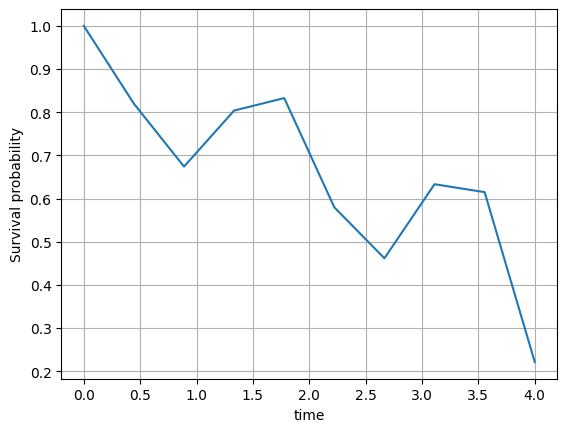

In [4]:
import numpy as np
cr = ClassicalRegister(Qbits)
qc = Trotter_evol(ini_state, 4, 3)
qc.measure_all()

initial_state = '00100111'
def P_meas(t, Ns, tot_shots=5000):
    qc = Trotter_evol(ini_state, t, Ns)
    qc.measure_all()
    simulator = Aer.get_backend('aer_simulator')
    tot_shots=tot_shots
    trans_circuit = transpile(qc, backend=simulator)
    job = simulator.run(trans_circuit, shots=tot_shots)
    counts = job.result().get_counts(qc)
    p0 = counts.get(initial_state, 0)/tot_shots
    return p0

t = np.linspace(0, 4, 10)
p_array = []
for l in t:
    p_array.append(P_meas(l,7))
plt.plot(t, p_array)
plt.xlabel('time')
plt.ylabel('Survival probability')
plt.grid(True)